In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pickle
import numpy as np
from skimage import transform
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.layers import experimental, Activation, InputLayer
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read a pickle file and disply its samples
# Note that image data are stored as unit8 so each element is an int from 0-255
data = pickle.load( open( '/content/drive/MyDrive/Colab Notebooks/MP3/Train.pkl', 
                         'rb' ), encoding='bytes')

test_data=pickle.load(open( '/content/drive/MyDrive/Colab Notebooks/MP3/Test.pkl',
                             'rb' ), encoding='bytes')
targets=np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/MP3/TrainLabels.csv', 
                      delimiter=',', skip_header=1)[:,1:]
#plt.imshow(data[1234,:,:],cmap='gray', vmin=0, vmax=256)
print(data.shape, targets.shape)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
le =LabelEncoder()
labels=le.fit_transform(targets.flatten())
labels=to_categorical(labels,num_classes=9)
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3,
                                                    random_state=42)

x_test = x_test.reshape((x_test.shape[0], 64, 128, 1)).astype("float32")/255
test_data=test_data.reshape((test_data.shape[0],64,128,1)).astype("float32")/255
x_train= x_train.reshape((x_train.shape[0], 64, 128, 1)).astype("float32")/255

(60000, 64, 128) (60000, 1)


**Run the following code only when training set is NOT to be split**

In [ ]:
x_train = data
y_train = labels

from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train)

x_train= x_train.reshape((x_train.shape[0], 64, 128, 1)).astype("float32")/255

print(x_train.shape, y_train.shape)
print(test_data.shape)

**Modified ResNet**

In [ ]:
inputs = keras.Input(shape=(64,128, 1), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)
 
x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])
 
x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])
 
x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_3_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_4_output = layers.add([x, block_3_output])
 
x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_4_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_5_output = layers.add([x, block_4_output])
 
x = layers.Conv2D(64, 3, activation="relu")(block_5_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(9)(x)
 
model = keras.Model(inputs, outputs, name="modified_resnet")
model.summary()

Model: "modified_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 64, 128, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 62, 126, 32)  320         img[0][0]                        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 60, 124, 64)  18496       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 20, 41, 64)   0           conv2d_1[0][0]                   
____________________________________________________________________________________

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["acc"],
)
early=EarlyStopping(monitor='val_acc',min_delta=0,patience=10,verbose=1,
                    mode='auto')
history = model.fit(x_train, y_train, batch_size=64, epochs=200, 
                    validation_split=0.2,callbacks=[early])

Epoch 1/200
525/525 [==============================] - 31s 59ms/step - loss: 2.1113 - acc: 0.1629 - val_loss: 1.7991 - val_acc: 0.2837
Epoch 2/200
525/525 [==============================] - 31s 59ms/step - loss: 1.6890 - acc: 0.3191 - val_loss: 1.3825 - val_acc: 0.4598
Epoch 3/200
525/525 [==============================] - 31s 60ms/step - loss: 1.4206 - acc: 0.4276 - val_loss: 1.7203 - val_acc: 0.3813
Epoch 4/200
525/525 [==============================] - 31s 59ms/step - loss: 1.2521 - acc: 0.5299 - val_loss: 1.1295 - val_acc: 0.6127
Epoch 5/200
525/525 [==============================] - 31s 59ms/step - loss: 1.0129 - acc: 0.6764 - val_loss: 0.7550 - val_acc: 0.7761
Epoch 6/200
525/525 [==============================] - 31s 59ms/step - loss: 0.7782 - acc: 0.7670 - val_loss: 0.8787 - val_acc: 0.7240
Epoch 7/200
525/525 [==============================] - 31s 60ms/step - loss: 0.6632 - acc: 0.8049 - val_loss: 0.6175 - val_acc: 0.8220
Epoch 8/200
525/525 [==============================] - 

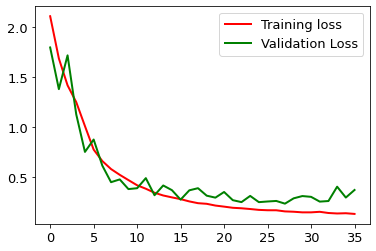

In [ ]:
model_loss = pd.DataFrame(history.history)
plt.rcParams.update({'font.size': 13})
plt.plot(model_loss['loss'][:-2],'r',linewidth=2.0)
plt.plot(model_loss['val_loss'][:-2],'g',linewidth=2.0)
plt.legend(['Training loss','Validation Loss'])
plt.savefig('Loss.png',dpi=600)

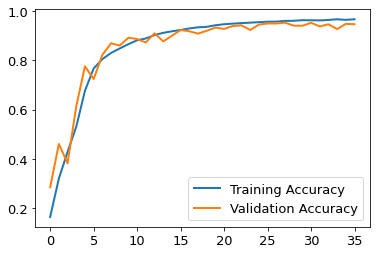

In [ ]:
plt.plot(model_loss['acc'][:-2],linewidth=2.0)
plt.plot(model_loss['val_acc'][:-2],linewidth=2.0)
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('accuracy.png',dpi=600)

In [ ]:
test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

563/563 - 6s - loss: 0.2969 - acc: 0.9457
Test loss: 0.2969474792480469
Test accuracy: 0.9456666707992554


In [ ]:
test_data_pred = model.predict(test_data)

In [13]:
import numpy as np

test_prediction = []

for y_i in test_data_pred:
  test_prediction.append(np.argmax(y_i) + 5)

In [14]:
import pandas as pd

df = pd.DataFrame(columns=['class'])

df['class'] = test_prediction

df.to_csv('ResNet.csv', index=True)

from google.colab import files
files.download('ResNet.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

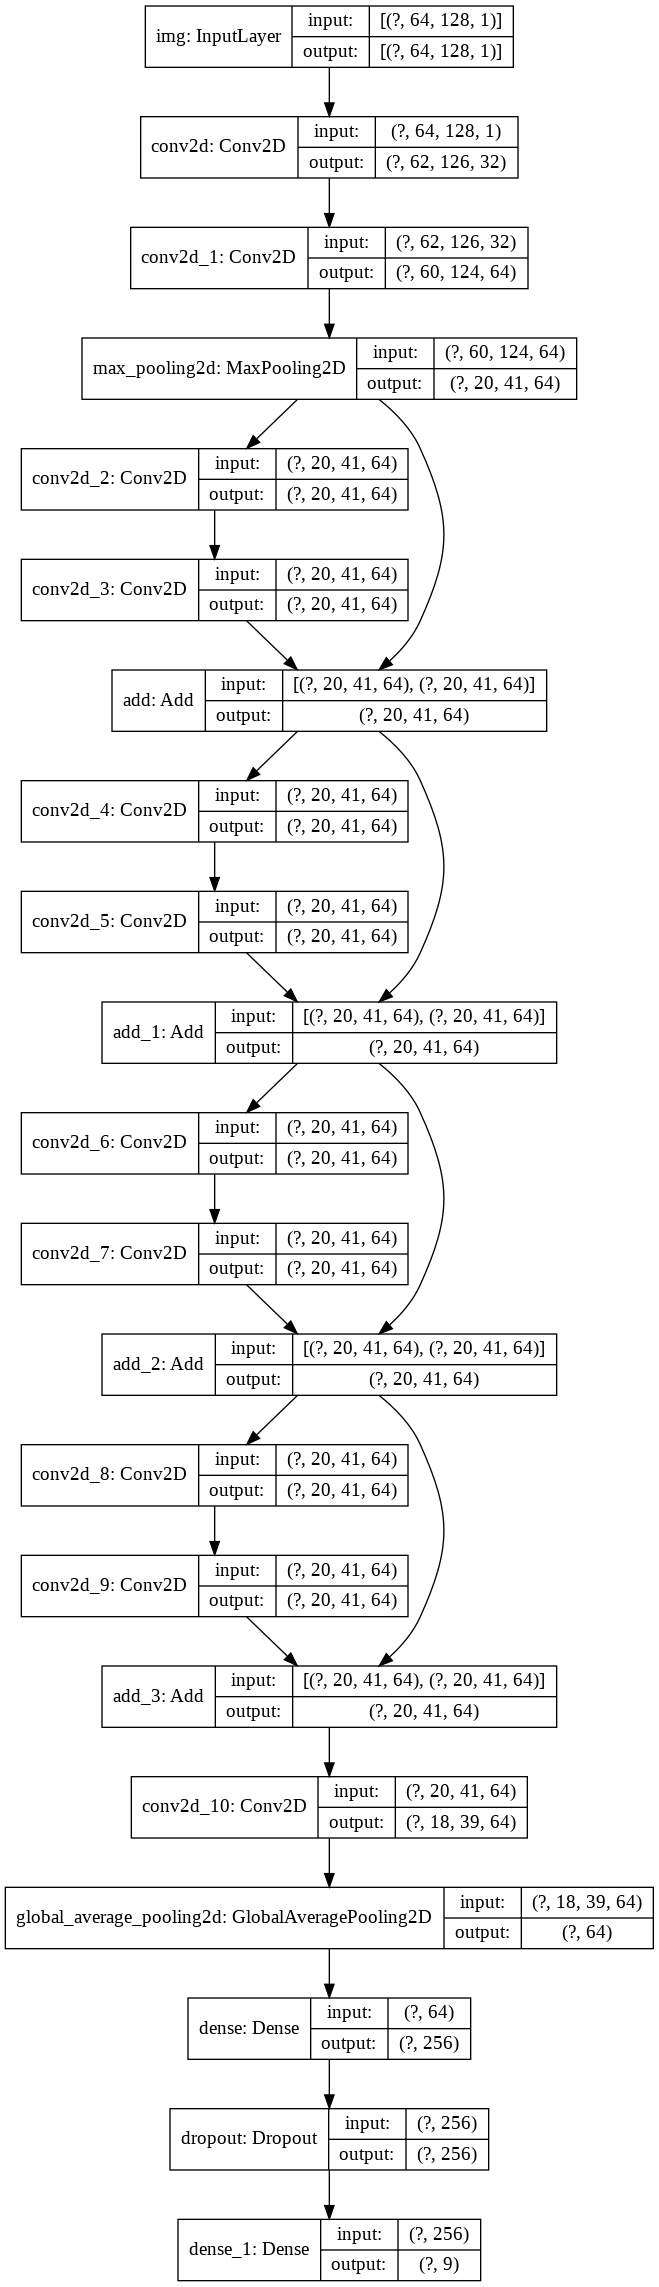

In [15]:
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)